In [1]:
'''
IMPORTS
'''

%matplotlib inline

# Standard imports
import copy
import itertools

# Scientific computing imports
import numpy
import matplotlib.pyplot as plt
import networkx as nx
import pandas
import collections
from bisect import bisect
from networkx.algorithms.flow import edmonds_karp
from random import choice

import seaborn; seaborn.set()

# Import widget methods
from IPython.html.widgets import *

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
class Ant(object):
    """
    Ant class, which encapsulates the entire behavior of an ant.
    """
    def __init__(self,model,ant_id,colony_id):
    
        # Set model link and ID
        self.model = model
        self.ant_id = (ant_id,colony_id)
        
    def random_walk(self,source,sink,alpha=1.0,beta=1.0):
        #Random Walk
        #initialize method
        self.alpha=alpha
        self.beta=beta
        self.source=source
        self.sink=sink
        self.g=nx.DiGraph()
        
        #initialize needed global data for heuristic
        self.capacity_list=self.get_capacity_list()
        
        #initialize start of random walk
        self.last_nodes=self.source
        
        #Create path for an ant
        terminate=0
        while not terminate:
            terminate=1
            for i in xrange(len(self.last_nodes)):
                '''
                Ant step is encompassed below
                '''
                #track next nodes
                self.last_nodes_next=[]
                
                #Get number of branches
                self.branch_pheromone_list=self.get_pheromone_branch(self.last_nodes[i])
                self.branches=self.make_decision(self.branch_pheromone_list)+1 #index of decision +1 is the number of branches chosen
                self.neighbors_chosen=[] #list other branches taken out of that node
                
                for branch in xrange(self.branches):
                    #get neighbors
                    self.base_node=self.last_nodes[i]
                    #self.base_node=self.last_nodes.pop()
                    self.all_p_neighbors=self.get_neighbors(self.base_node)
                    self.p_neighbors=list(set(self.all_p_neighbors)-set(self.neighbors_chosen)) #prevent ants taking same branch

                    #get pheromone of each edge to neighbor
                    self.edge_pheromone_list=[]
                    for self.potential_node in self.p_neighbors:
                        self.edge_pheromone_list.append(self.get_pheromone_edge((self.base_node,self.potential_node)))

                    #get next node
                    self.next_node=self.p_neighbors[self.make_decision(self.edge_pheromone_list)]
                    self.neighbors_chosen.append(self.next_node) #record branch taken
                    self.last_nodes_next.append(self.next_node)

                    #add edge
                    self.g.add_edge(self.base_node,self.next_node)
                    #print(self.g.nodes())

                    #get capacity pheromones
                    capacity_pheromone_list=self.get_pheromone_capacity((self.base_node,self.next_node))
                    
                    #get capacity heuristic
                    cap_in=0
                    for node_key in space.g.pred[self.base_node]:
                        cap_in+=space.g.pred[self.base_node][node_key]['capacity']
                    
                    heuristic_list=[]
                    for cap in self.capacity_list:
                        #heuristic_list.append((1.0/(1.0+abs(cap_in-cap)))**self.beta)
                        if cap_in-cap>0:
                            heuristic_value=1.0/(1.0+abs(cap_in-cap))
                        else:
                            heuristic_value=2
                            
                        heuristic_list.append(heuristic_value**self.beta)
                    #apply heuristic to capacity pheromones
                    self.adjusted_pheromone_list=[]
                    for j in xrange(len(capacity_pheromone_list)):
                        self.adjusted_pheromone_list.append((capacity_pheromone_list[j]**self.alpha)*heuristic_list[j])

                    #decide capacity
                    self.capacity_to_add=self.model.capacities[self.make_decision(self.adjusted_pheromone_list)]

                    #add capacity
                    self.g[self.base_node][self.next_node]['capacity']=self.capacity_to_add

                #Check termination criteria - are all sinks in the graph
                for sink_node in self.sink:
                    if sink_node not in self.g:
                        terminate=0
                        
            self.last_nodes=list(set(self.last_nodes_next))   

        return (self.g)
    
    def get_neighbors(self,node):
        """
        Return neighbors, calling through model.
        """
        return self.model.get_ant_neighbors(node)
    
    def make_decision(self,pheromone_list):
        """
        Return decision index, based on pheromone list.
        """
        #convert pheromones to percentage
        self.percent_list = [float(i)/sum(pheromone_list) for i in pheromone_list]   
        self.cumulative_percent=numpy.cumsum(self.percent_list)

        #Choose decision index
        self.select_index=bisect(self.cumulative_percent,numpy.random.uniform(0,1,1))
  
        return self.select_index
    
    def get_capacity_list(self):
        """
        Returns the capacity list from the space
        """
        return self.model.capacities
    
    def get_pheromone_branch(self,node):
        """
        Return node pheromone, calling through model.
        """    
        return self.model.get_branch_pheromone(node,self.ant_id)
    
    def get_pheromone_edge(self,edge):
        """
        Return edge pheromone, calling through model.
        """
        return self.model.get_edge_pheromone(edge,self.ant_id)

    def get_pheromone_capacity(self,edge):
        """
        Return edge pheromone, calling through model.
        """
        return self.model.get_capacity_pheromone(edge,self.ant_id)
    

    def __repr__(self):
        '''
        Return string representation.
        '''
        skip_none = True
        repr_string = type(self).__name__ + " ["
        except_list = "model"

        elements = [e for e in dir(self) if str(e) not in except_list]
        for e in elements:
            # Make sure we only display "public" fields; skip anything private (_*), that is a method/function, or that is a module.
            if not e.startswith("_") and eval('type(self.{0}).__name__'.format(e)) not in ['DataFrame', 'function', 'method', 'builtin_function_or_method', 'module', 'instancemethod']:
                    value = eval("self." + e)
                    if value != None and skip_none == True:
                        repr_string += "{0}={1}, ".format(e, value)

        # Clean up trailing space and comma.
        return repr_string.strip(" ").strip(",") + "]"

    

In [40]:
class Space(object):
    """
    Space class, which encapsulates the entire behavior of a single "run" ACO.
    """
    def __init__(self, size,num_ants=1,num_colonies=2,source=[[(0,0)],[10]],sink=[[(2,2)],[5]],
                 dissipation=.2,initial_pheromone=.1,capacities=[1,5,10],alpha=1.0,beta=1.0,percent_removals=.1):
        """
        Class constructor.
        """
        # Set our model parameters
        self.size = size
        self.sink = sink[0]
        self.sink_magnitude = sink[1]
        self.source=source[0]
        self.source_magnitude = source[1]        
        self.num_ants=num_ants
        self.num_colonies=num_colonies
        self.dissipation=dissipation
        self.initial_pheromone=initial_pheromone
        self.capacities=capacities
        self.alpha=alpha
        self.beta=beta
        self.percent_removals=percent_removals
        
        # Set our state variables
        self.t = 0
        self.ants = []
        self.ant_graphs=[]
        #self.global_scores=[]

        
        # Call our setup methods to initialize space, people, and institution.
        self.setup_space()
        self.setup_ants()
        

    def setup_space(self):
        """
        Method to setup our space.
        """
        # Initialize a space with a grid network
        self.g = nx.grid_graph(dim=self.size)
        self.g=self.g.to_directed()
        
        #Set Pheromones
        print('Setting up network')
        for e in self.g.edges_iter():
            self.g.add_edge(e[0],e[1],capacity=0) #initial capacity 
            self.g.add_edge(e[0],e[1],edge_pheromone=[self.initial_pheromone]*2) #pheromone per edge
            self.g.add_edge(e[0],e[1],capacity_pheromone=[[self.initial_pheromone]*len(self.capacities)]*2) #pheromone per capacity
        
        for n in self.g.nodes_iter():
            neighbors_n=self.g.neighbors(n)
            pheromone_list=[]
            for num in xrange(len(neighbors_n)):
                #pheromone_list.append((num+1)/10.0)
                pheromone_list.append(numpy.exp(-num*2))
                
            #pheromone_list.reverse()
            pheromone_list=[1.0]
            pheromone_list.extend([0]*(len(neighbors_n)-1))
            #print pheromone_list
            self.g.add_node(n,branch_pheromone=[pheromone_list]*2)
            #self.g.add_node(n,branch_pheromone=[[self.initial_pheromone]*len(neighbors_n)]*2)
            
        self.g_layout = nx.spectral_layout(self.g)
 
        
    def setup_ants(self):
        """
        Method to setup our space.
        """       
        # First, begin by creating all ants.
        int_id=0 #set up list ID of ants
        self.ant_id_dict={} #set up dict converting ant id to list id
        for c in xrange(self.num_colonies):
            for i in xrange(self.num_ants):
                self.ants.append(Ant(model=self,ant_id=(i+1),colony_id=(c+1)))
                self.ant_id_dict[(i,c)]=int_id                
                int_id+=1
        #print self.ant_id_dict
         
    def get_branch_pheromone(self,node,ant_id):     
        """
        Get branch decision pheromone for ant call
        """          
        ant_weight=float(ant_id[0]-1)/(self.num_ants-1)
        pheromone_1=self.g.node[node]['branch_pheromone'][0]
        pheromone_2=self.g.node[node]['branch_pheromone'][1]
    
        weighted_pheromone_1=[i**ant_weight for i in pheromone_1]
        weighted_pheromone_2=[i**(1-ant_weight) for i in pheromone_2]
        composite_pheromone=[weighted_pheromone_1[i]*weighted_pheromone_2[i] for i in xrange(len(weighted_pheromone_1))]
        
        return composite_pheromone
            
    def get_edge_pheromone(self,edge,ant_id):
        """
        Get edge decision pheromone for ant call
        """        
        ant_weight=float(ant_id[0])/(self.num_ants-1)
        pheromone_1=self.g[edge[0]][edge[1]]['edge_pheromone'][0]
        pheromone_2=self.g[edge[0]][edge[1]]['edge_pheromone'][1]
                
        return (pheromone_1**ant_weight)*(pheromone_2**(1-ant_weight))
    
    def get_capacity_pheromone(self,edge,ant_id):
        """
        Get capacity decision pheromone for ant call
        """  
        ant_weight=float(ant_id[0])/(self.num_ants-1)
        pheromone_1=self.g[edge[0]][edge[1]]['capacity_pheromone'][0]
        pheromone_2=self.g[edge[0]][edge[1]]['capacity_pheromone'][1]
        
        weighted_pheromone_1=[i**ant_weight for i in pheromone_1]
        weighted_pheromone_2=[i**(1-ant_weight) for i in pheromone_2]
        composite_pheromone=[weighted_pheromone_1[i]*weighted_pheromone_2[i] for i in xrange(len(weighted_pheromone_1))]
        
        return composite_pheromone
        
        
    def get_ant_neighbors(self,node):
        """
        Get node neighbors for ant call
        """
        return self.g.neighbors(node)
            
    def get_path(self, ant_id):
        """
        Get the path of an ant based on their ID.
        """
        ant_list_id=self.ant_id_dict[ant_id]
        return self.ants[ant_list_id].random_walk(self.source,self.sink,self.alpha,self.beta)
    
    def flow_test(self,graph):
        """
        Calculates the flow from sources to sinks in a graph.
        
        """
        flow_graph=copy.deepcopy(graph)
        for i in xrange(len(self.sink)):
            flow_graph.add_edge(self.sink[i],'sink',capacity=self.sink_magnitude[i])
        
        #add aggregate source
        flow_graph.add_node('place_holder') #fixes indexing error in maximum_flow
        for i in xrange(len(self.source)):
            flow_graph.add_edge('source',self.source[i],capacity=self.source_magnitude[i])
        
        #get initial flow values
        flow_value, flow_dict = nx.maximum_flow(flow_graph, 'source', 'sink')
        
        return flow_value
    
    def complexity_score(self,graph):
        """
        Calculates the complexity of a graph.
        
        """
        complexity_graph=copy.deepcopy(graph)
        length_score=complexity_graph.number_of_edges()
        node_score=complexity_graph.number_of_nodes()
        e_val, e_vec=numpy.linalg.eig(nx.adjacency_matrix(complexity_graph).todense())
        complexity=sum(abs(e_val))
        complexity_value=(length_score+2*node_score)+complexity #+(length_score+node_score)
        
        return complexity_value
    
    def evaluate_graph(self, ant_graph):
        """
        Score graphs based on criteria.
        """
                
        #Score 1 - Flow        
        #get initial flow values
        flow_value_ini=self.flow_test(ant_graph)
        flow_score_ini=float(flow_value_ini)/sum(self.sink_magnitude)
        satisfy_flow=1
        if flow_score_ini!=1:
            satisfy_flow=0
            return (0,0),satisfy_flow
        
        #percolate and test flow
        percolation_graph=copy.deepcopy(ant_graph)
        space_graph = nx.grid_graph(dim=self.size)
        num_edge_pairs=space_graph.number_of_edges()
        space_graph=space_graph.to_directed()
        base_percolation_graph=nx.compose(space_graph,percolation_graph)
        #num_removals=int(numpy.rint(self.percent_removals*ant_graph.number_of_edges()))
        num_removals=int(numpy.rint(num_edge_pairs*self.percent_removals))
        
        survivability_flow=0
        num_trials=10
        for i in xrange(num_trials):
            percolation_graph=copy.deepcopy(base_percolation_graph)
            for i in xrange(num_removals):
                edge_removed=choice(percolation_graph.edges())
                percolation_graph.remove_edge(edge_removed[0],edge_removed[1])
                percolation_graph.remove_edge(edge_removed[1],edge_removed[0])
                flow_increment=self.flow_test(percolation_graph)
                if flow_increment==0:
                    break
                else:
                    survivability_flow+=flow_increment

        #flow is judged by the amount of flow that gets to the aggregate sink based on the total sink magnitude 
        flow_score_ini=float(flow_value_ini)/sum(self.sink_magnitude)
        survivability_score=float(survivability_flow)/(sum(self.sink_magnitude)*num_removals*num_trials)
        
        #Score 2 - Complexity
        complexity_score=self.complexity_score(ant_graph)
        
        return (survivability_score,complexity_score),satisfy_flow
    
    def dominates(self, point_1, point_2, equality_sequence):
        '''
        Calculates if a point is dominated by another point, used in simple_cull_front
        equality_sequence:= 1 is '>=',0 is '<='
        '''
        score=0
        for i in range(len(point_1)):
            if equality_sequence[i]==1 and point_1[i]>=point_2[i]:
                score+=1
            elif equality_sequence[i]==0 and point_1[i]<=point_2[i]:
                score+=1
        dom=score==len(point_1)    
        return dom    
   
    def simple_cull_front(self, inputPoints, dominates, equality_sequence):
        '''
        Basic algorithm to find the pareto front of a set of points
        min or max is determined based on equality_sequence:= 0 is min, 1 is max
        '''
        paretoPoints = set()
        candidateRowNr = 0
        dominatedPoints = set()
        while True:
            candidateRow = inputPoints[candidateRowNr]
            inputPoints.remove(candidateRow)
            rowNr = 0
            nonDominated = True
            while len(inputPoints) != 0 and rowNr < len(inputPoints):
                row = inputPoints[rowNr]
                if self.dominates(candidateRow, row,equality_sequence):
                    # If it is worse on all features remove the row from the array
                    inputPoints.remove(row)
                    dominatedPoints.add(tuple(row))
                elif self.dominates(row, candidateRow, equality_sequence):
                    nonDominated = False
                    dominatedPoints.add(tuple(candidateRow))
                    rowNr += 1
                else:
                    rowNr += 1

            if nonDominated:
                # add the non-dominated point to the Pareto frontier
                paretoPoints.add(tuple(candidateRow))

            if len(inputPoints) == 0:
                break
        return paretoPoints, dominatedPoints

    
    def ant_ranking(self, ant_graphs):
        """
        Find best Ants based on scores from evaluate_graph.
        """
        score_list=[]
        num_ants_generation=self.num_ants*self.num_colonies
        #[score_list.append(graph[1]) for graph in ant_graphs[-num_ants_generation:]] #Generation Pareto
        [score_list.append(graph[1]) for graph in ant_graphs] #Global Pareto
        cull_scores=score_list[:]
        equality_sequence=[1,0] #[>=,<=]
        self.paretoPoints, self.dominatedPoints=self.simple_cull_front(cull_scores,self.dominates,equality_sequence)
        self.paretoPoints=list(self.paretoPoints)

        best_ants_index=[]
        
        #match the score_list indices to the pareto front values
        for i in xrange(len(score_list)):
            if score_list[i] in self.paretoPoints:
                best_ants_index.append(i)
                #print 'pareto score @',i,':',score_list[i]
                
        return best_ants_index, score_list
    
    
    def step(self):
        """
        Model step function.
        """
        #Ants make paths
        #self.ant_graphs=[] #exclude for initialized in setup for global pareto front
        
        #Step for each ant
        for c in xrange(self.num_colonies):
            for i in xrange(self.num_ants):
                sat_flow=0
                while sat_flow==0:
                    self.ant_graph=self.get_path((i,c))

                    #Evaluate Paths
                    self.graph_score,sat_flow=self.evaluate_graph(self.ant_graph) 
                    #print sat_flow

                #List <graph,score>
                self.ant_graphs.append((self.ant_graph,self.graph_score))
            
        #Get best score
        self.opt_ant,self.score_list=self.ant_ranking(self.ant_graphs)
        
        #Update Institutions - Edges and capacities for this walk
        #Get pheromones
        self.edge_pheromone_dict=nx.get_edge_attributes(self.g,'edge_pheromone')
        self.capacity_pheromone_dict=nx.get_edge_attributes(self.g,'capacity_pheromone')
        self.branch_pheromone_dict=nx.get_node_attributes(self.g,'branch_pheromone')
        
        #Reduce edge pheromones by input amount
        for key in self.edge_pheromone_dict:    
            self.edge_pheromone_dict[key][0]*=(1-self.dissipation)      
            self.edge_pheromone_dict[key][1]*=(1-self.dissipation)
        
        #for key in self.capacity_pheromone_dict: #Update capacities of all paths
            #for i in xrange(len(self.capacity_pheromone_dict[key][0])):
                #self.capacity_pheromone_dict[key][0][i]*=(1-self.dissipation)
                #self.capacity_pheromone_dict[key][1][i]*=(1-self.dissipation)
                
        #Increment through best paths to update
        for ph_index in xrange(2):
            for ant in self.opt_ant:
                for e in self.ant_graphs[ant][0].edges():
                    #increase the pheromone amount of edges traveled by best ants
                    if ph_index == 0: #flow
                        pheromone_increment=self.score_list[ant][ph_index]/10.0 #increment for flow
                    else:
                        pheromone_increment=1.0/(self.score_list[ant][ph_index]) #increment for length
                        
                    self.edge_pheromone_dict[e][ph_index]+=pheromone_increment #1.0/(len(self.opt_ant)) #1/(self.score_list[ant][ph_index])

                    #get capacity chosen and update pheromones
                    self.capacity_chosen=self.ant_graphs[ant][0][e[0]][e[1]]['capacity']
                    self.capacity_index=self.capacities.index(self.capacity_chosen)
                    for i in xrange(len(self.capacity_pheromone_dict[e])):
                        self.capacity_pheromone_dict[e][ph_index][i]*=(1-self.dissipation) #Update capacities of only travelled paths
                        #add pheromone if one chosen
                        if i == self.capacity_index:
                            self.capacity_pheromone_dict[e][ph_index][i]+=pheromone_increment #1.0/(len(self.opt_ant)) #1/(self.score_list[ant][ph_index])                                   
        
        
                for n in self.ant_graphs[ant][0].nodes():
                    #increase the pheromone amount of nodes traveled by best ants
                    if ph_index == 0: #flow
                        pheromone_increment=self.score_list[ant][ph_index]/10.0 #increment for flow
                    else:
                        pheromone_increment=1.0/(self.score_list[ant][ph_index]) #increment for length
                        
                    self.branches_chosen=len(self.ant_graphs[ant][0].neighbors(n))
                    self.branches_index=self.branches_chosen-1
                    for i in xrange(len(self.branch_pheromone_dict[n])):
                        self.branch_pheromone_dict[n][ph_index][i]*=(1-self.dissipation)
                        if i==self.branches_index:
                            self.branch_pheromone_dict[n][ph_index][i]+=pheromone_increment
                    
                    
        
        #Set new edge pheromones
        nx.set_edge_attributes(self.g, 'edge_pheromone', self.edge_pheromone_dict)
        
        #Set new capacity pheromones
        nx.set_edge_attributes(self.g, 'capacity_pheromone', self.capacity_pheromone_dict)
        
        #Set new branch pheromones
        nx.set_node_attributes(self.g, 'branch_pheromone', self.branch_pheromone_dict)
        

In [4]:
def visualize_system(system,area):
    # Remove the nonpath from path nodes
    nonpath_nodes = [node for node in area.nodes() if node not in system]

    area_layout=nx.spectral_layout(area)
    # Now we can visualize the infected node's position
    f = plt.figure()
    nx.draw_networkx_nodes(system, area_layout,
                           node_color='red',edge_color='red')

    nx.draw_networkx_nodes(area, area_layout,
                           nodelist=nonpath_nodes,
                           node_color='#dddddd')

    nx.draw_networkx_edges(area, area_layout, 
                           width=1.0, 
                           alpha=0.5,
                           edge_color='#111111')

    nx.draw_networkx_edges(system, area_layout,
                          edgelist=system.edges(),
                          width=1.0, 
                          alpha=0.5,
                          edge_color='red')

    _ = nx.draw_networkx_labels(area, area_layout,
                            dict(zip(area.nodes(), area.nodes())),
                            font_size=10)
    _ = nx.draw_networkx_labels(area, area_layout,
                            dict(zip(area.nodes(), area.nodes())),
                            font_size=10)



Setting up network
Pareto front of generation 1 : [(0.8178571428571428, 73.776747344327418), (0.8571428571428571, 77.064513754075818), (0.7892857142857143, 68.363850388076401), (0.7214285714285714, 62.762026756194082), (0.8464285714285714, 74.928729295365272)]
Pareto front of generation 2 : [(0.6285714285714286, 50.548031049910094), (0.925, 77.735261013107447), (0.775, 55.43115872059532), (0.8964285714285715, 62.56906237599064), (0.8821428571428571, 60.665324049673217)]
Pareto front of generation 3 : [(0.8857142857142857, 49.324555320336756), (0.9107142857142857, 72.285577254753335), (0.8964285714285715, 62.56906237599064), (0.8892857142857142, 57.47213595499958), (0.925, 77.735261013107447)]
Pareto front of generation 4 : [(0.8357142857142857, 47.0), (0.9071428571428571, 47.818625825113529), (0.9214285714285714, 53.252543532874299), (0.8678571428571429, 47.464101615137757), (0.9464285714285714, 66.042029350656506)]
Pareto front of generation 5 : [(0.9071428571428571, 47.81862582511352

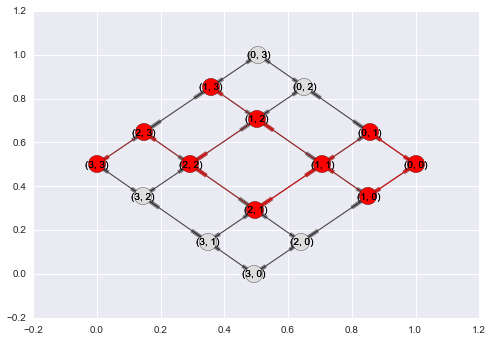

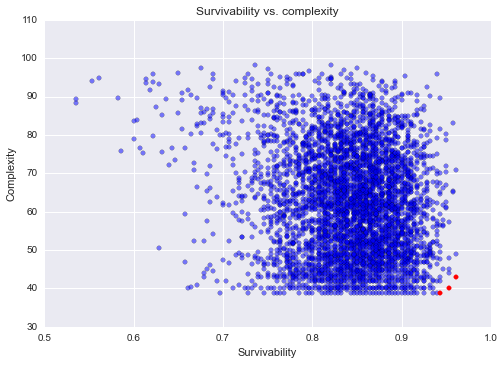

In [41]:
'''
Run Example
'''

space=Space(size=[4,4],num_ants=10,num_colonies=10,source=[[(0,0)],[20]],
            sink=[[(3,3),(1,3)],[10,10]], initial_pheromone=1,beta=1.0,
            capacities=[5,10,15],percent_removals=.3)

#space=Space(size=[5,5,3],num_ants=10,num_colonies=10,source=[[(0,3,0),(0,1,0)],[20,20]],
            #sink=[[(3,2,2),(1,4,2),(4,4,2),(3,4,0)],[10,10,15,5]],
            #initial_pheromone=1,beta=2.0,capacities=[5,10,15,20])
converged=0
i=1
while not converged:
    space.step()
    print 'Pareto front of generation',i,':',space.paretoPoints 
    i+=1
    if i>50:
        converged=1
        

print('Ant Path')

    

# Remove the nonpath from path nodes
nonpath_nodes = [node for node in space.g.nodes() if node not in space.ant_graphs[space.opt_ant[0]][0]]

# Now we can visualize the infected node's position
visualize_system(space.ant_graphs[space.opt_ant[-1]][0],space.g)

#Plot Solutions
front_x=[i[0] for i in space.paretoPoints]
front_y=[i[1] for i in space.paretoPoints]
dominated_x=[i[0] for i in space.dominatedPoints]
dominated_y=[i[1] for i in space.dominatedPoints]
f = plt.figure()
plt.scatter(dominated_x,dominated_y,alpha=0.5)
plt.scatter(front_x,front_y,color='red',alpha=1)
plt.xlabel("Survivability")
plt.ylabel("Complexity")
plt.title("Survivability vs. complexity")

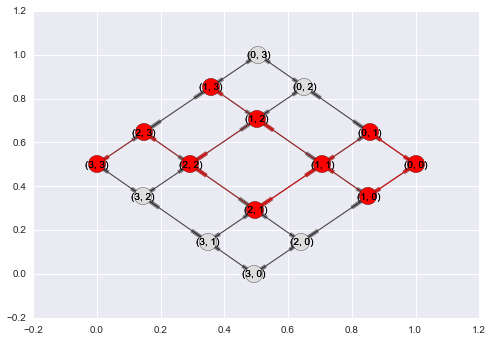

In [46]:
visualize_system(space.ant_graphs[space.opt_ant[2]][0],space.g)

In [ ]:
visualize_system(space.ant_graphs[space.opt_ant[-1]][0],space.g)

front_x=[i[0] for i in space.paretoPoints]
front_y=[i[1] for i in space.paretoPoints]
dominated_x=[i[0] for i in space.dominatedPoints]
dominated_y=[i[1] for i in space.dominatedPoints]
print front_x
f = plt.figure()
plt.scatter(dominated_x,dominated_y,alpha=0.5)
plt.scatter(front_x,front_y,color='red',alpha=0.5)
plt.xlabel("Survivability")
plt.ylabel("Complexity")
plt.title("Survivability vs. complexity")

In [91]:
A=copy.deepcopy(space.ant_graphs[space.opt_ant[0]][0])
print A.is_directed()
L=nx.normalized_laplacian_matrix(A.to_undirected())
e = numpy.linalg.eigvals(L.A)
print sum(abs(e))
print choice(A.edges())

True
12.0
((0, 0), (0, 1))


In [18]:
A=copy.deepcopy(space.ant_graphs[space.opt_ant[-1]][0])
C=nx.adjacency_matrix(A)
#L=nx.normalized_laplacian_matrix(A.to_undirected())
e = numpy.linalg.eigvals(C.todense())
print sum(abs(e))

0.0


In [64]:
nx.get_edge_attributes(space.g,'edge_pheromone')

{((0, 0), (0, 1)): [0.9643392431982416, 0.27235761774043893],
 ((0, 0), (1, 0)): [0.9643392431982416, 0.27235761774043893],
 ((0, 1), (0, 0)): [0.002510948407885485, 0.00019840350070789744],
 ((0, 1), (0, 2)): [0.9639027910125928, 0.272300564343602],
 ((0, 1), (1, 1)): [0.9643358632415475, 0.27235745601108075],
 ((0, 2), (0, 1)): [1.8928918984398673e-05, 1.4464018700116436e-05],
 ((0, 2), (0, 3)): [3.73698549062398e-05, 1.4987218686340476e-05],
 ((0, 2), (1, 2)): [3.652486573270174e-05, 1.5061480619523103e-05],
 ((0, 3), (0, 2)): [3.260771660863691e-05, 1.4888769491650111e-05],
 ((0, 3), (1, 3)): [3.810740559379539e-05, 1.5065874910197449e-05],
 ((1, 0), (0, 0)): [0.6336226820507886, 0.098843494519969183],
 ((1, 0), (1, 1)): [0.9643338445595082, 0.27235730788413071],
 ((1, 0), (2, 0)): [0.5434821572991908, 0.20539992881236435],
 ((1, 1), (0, 1)): [0.00021103315637162557, 2.3663006527130765e-05],
 ((1, 1), (1, 0)): [0.00020538209638661177, 2.1362973494527445e-05],
 ((1, 1), (1, 2)): [0.

In [108]:
nx.get_node_attributes(space.g,'branch_pheromone')

{(0, 0): [[1e-323, 0.2083333333333334], [1e-323, 0.2083333333333334]],
 (0, 1): [[0.2083333333333334, 9.8813129168249309e-324, 0],
  [0.2083333333333334, 9.8813129168249309e-324, 0]],
 (0, 2): [[2.9702134201562047e-06, 1.0099123926455201e-06, 0],
  [2.9702134201562047e-06, 1.0099123926455201e-06, 0]],
 (0, 3): [[0.29635301355651894, 0.15238737614782835],
  [0.29635301355651894, 0.15238737614782835]],
 (1, 0): [[9.8813129168249309e-324, 0.2083333333333334, 0],
  [9.8813129168249309e-324, 0.2083333333333334, 0]],
 (1, 1): [[9.8813129168249309e-324, 0.2083333333333334, 0, 0],
  [9.8813129168249309e-324, 0.2083333333333334, 0, 0]],
 (1, 2): [[1e-323, 0.2083333333333334, 0, 0],
  [1e-323, 0.2083333333333334, 0, 0]],
 (1, 3): [[9.8813129168249309e-324, 9.8813129168249309e-324, 0],
  [9.8813129168249309e-324, 9.8813129168249309e-324, 0]],
 (2, 0): [[0.2083333333333334, 9.8813129168249309e-324, 0],
  [0.2083333333333334, 9.8813129168249309e-324, 0]],
 (2, 1): [[0.2083333333333334, 9.8813129168

In [39]:
g=nx.grid_graph([4,4])
print g.number_of_edges()
g=g.to_directed()
print g.number_of_edges()


24
48
